In [2]:
import numpy as np
import os
if 'notebooks' in os.listdir('../'):
    os.chdir('../')

import sys
sys.path.append('./scripts/')
sys.path.append('./scripts/training_scripts/')
sys.path.append('./scripts/inference_scripts')




from config import*

from training_utils import*
from inference_utils import*

import cv2
import matplotlib.pyplot as plt



# 1. Create config variable

In [3]:
json_path = 'json_templates/config_MnFeNiCuZnO_-110.json'

In [4]:
config = Config(json_path)

Directory experiments/MnFeNiCuZnO_-110/json_templates/ already exists!
Saving config_06-15-2022_09-49-31.json in experiments/MnFeNiCuZnO_-110/json_templates/


# 2. Set the FCN model

In [5]:
results_folder_path = config.model_kwargs.results_folder_path


path = os.path.join(results_folder_path,
                   'training_results/')
path = os.path.join(path,
                   'weights/')

In [6]:
make_config_proto()

In [7]:
model, optimizer, loss_object = compile_model(config)

In [8]:
epoch = 542

model.load_weights(os.path.join(path,'epoch-{}.h5'.format(epoch)))

# 3. Load and preprocess the exp image

In [62]:
#file_path = 'experiments/MnFeNiCuZnO_-110/data/experimental_images/exp-img-1.dm4'
file_path = 'experiments/MnFeNiCuZnO_-110/data/experimental_images/exp-img-2.dm4'

In [63]:
exp_img = read_exp_img(file_path,file_format='dm4')


Raw experimental image shape: (512, 512)


In [64]:
# experimental image on 8.5 x 8.5 nm and 512 x 512 pix
spatial_domain_exp_img = (8.5,8.5)
img_size_exp_img = exp_img.shape
resolution_exp_img = 10 * spatial_domain_exp_img[0] / img_size_exp_img[0]

# training done on 8.5 x 8.5 nm and 512 x 512 pix!
#spatial_domain_training = (8.5,8.5)
spatial_domain_training = (8.5,8.5)
img_size_training = (512,512)
resolution_training = 10 * spatial_domain_training[0] / img_size_training[0]

# the successful prediction is obtained on the same spatial domain as training!

n1_y = 0
delta_y =  int(spatial_domain_training[0] * 10 / resolution_exp_img) 

n1_x = 0
delta_x = int(spatial_domain_training[1] * 10 / resolution_exp_img) 

exp_img_zoom = exp_img[n1_y:n1_y + delta_y,
                       n1_x:n1_x + delta_x]

exp_img_res = cv2.resize(exp_img_zoom, img_size_training)
    
exp_img_norm = get_local_normalization(exp_img_res, resolution_training) 

exp_img_res = cv2.resize(exp_img, img_size_training)
    
exp_img_norm = get_local_normalization(exp_img_res, resolution_training) 

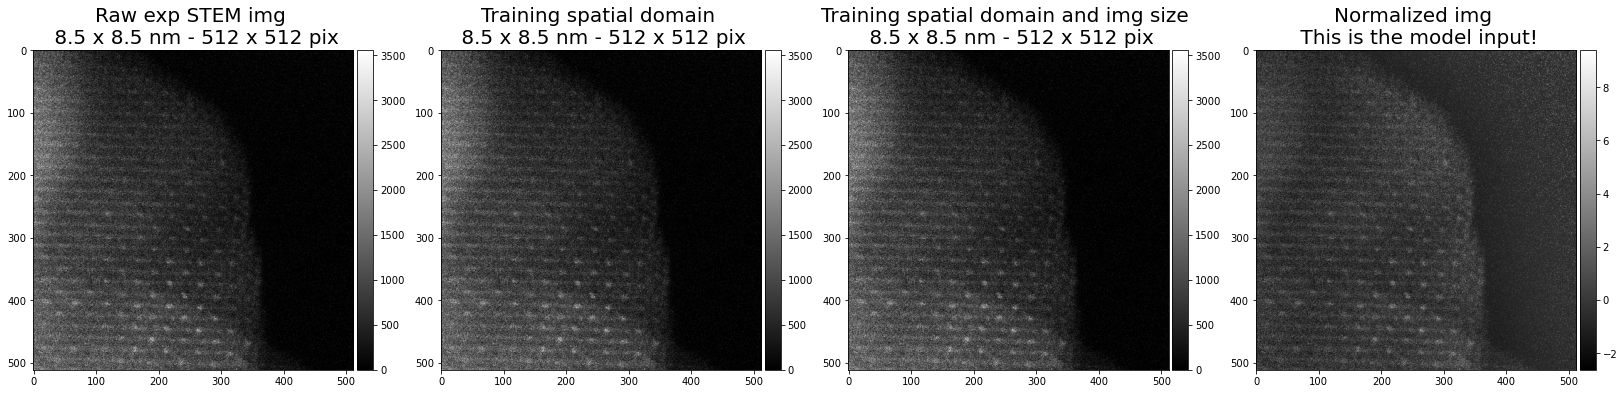

In [65]:
fig = plt.figure(figsize=(28, 14))

ax = fig.add_subplot(1, 4, 1)
im = ax.imshow(exp_img, cmap = 'gray')
plt.title('Raw exp STEM img \n {} x {} nm - {} x {} pix'.format(spatial_domain_exp_img[0],
                                                                spatial_domain_exp_img[1],
                                                                exp_img.shape[0],
                                                                exp_img.shape[1]), fontsize=20)
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax1)

ax = fig.add_subplot(1, 4, 2)
im = ax.imshow(exp_img_zoom, cmap = 'gray')
plt.title('Training spatial domain \n {} x {} nm - {} x {} pix'.format(spatial_domain_training[0],
                                                                       spatial_domain_training[1],
                                                                       exp_img_zoom.shape[0],
                                                                       exp_img_zoom.shape[1]), fontsize=20)

divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax1)

ax = fig.add_subplot(1, 4, 3)
im = ax.imshow(exp_img_res, cmap = 'gray')
plt.title('Training spatial domain and img size \n {} x {} nm - {} x {} pix'.format(spatial_domain_training[0],
                                                                                    spatial_domain_training[1],
                                                                                    exp_img_res.shape[0],
                                                                                    exp_img_res.shape[1]), fontsize=20)

divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax1)

ax = fig.add_subplot(1, 4, 4)
im = ax.imshow(exp_img_norm, cmap = 'gray')
plt.title('Normalized img \n This is the model input!', fontsize=20)
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax1)





# 4. Prediction

In [66]:
pred_exp_img = model(exp_img_norm.reshape((1,) + exp_img_norm.shape + (1,)),

                                          training = True)

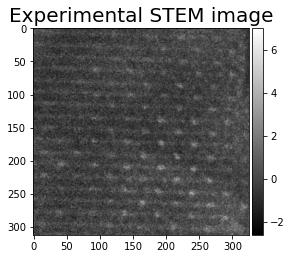

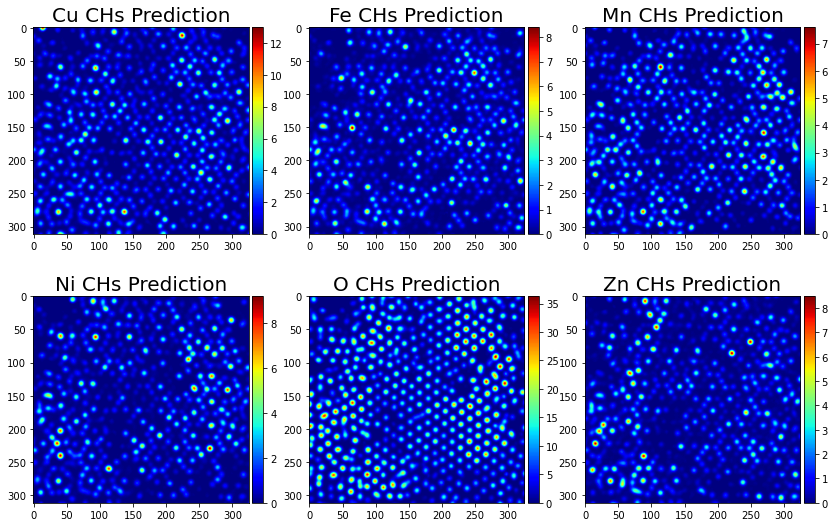

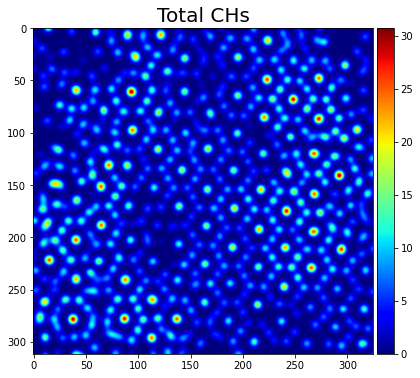

In [67]:
# for exp-img-2, zoom = True
n1_x = 50 - 25
delta_x = 350 - 25

n1_y = 200
delta_y = 400


plot_exp_img_predictions(exp_img_norm,
                         pred_exp_img,
                         ['Cu','Fe','Mn','Ni','O','Zn'],
                         n1_x,
                         delta_x,
                         n1_y,
                         delta_y,
                         zoom = True,
                         conc = False,
                         interpolation = 'gaussian')

In [56]:
elements = ['Cu','Fe','Mn','Ni','O','Zn']
n_elelemnts = len(elements)

In [57]:
from skimage.feature import peak_local_max

def get_peaks_pos(img,resolution):

        peaks_pos = peak_local_max(img,min_distance = int(1/resolution),threshold_abs = 1e-6)

        return peaks_pos

In [58]:
zoom = False

peaks = []
CHs = []

CH_tot = 0
for i in range(n_elelemnts):
    
    if zoom:
        pred_exp_img = pred_exp_img[:,n1_y:n1_y + delta_y,
                           n1_x:n1_x + delta_x, :]
    
    pred_element = pred_exp_img.numpy()[0,:,:,i]
    
    p = get_peaks_pos(pred_element,resolution_training)
    
    peaks.append(p)
    
    ch = pred_element[p[:,1],p[:,0]]
    
    CH_tot += sum(ch)
    
    CHs.append(ch)
    

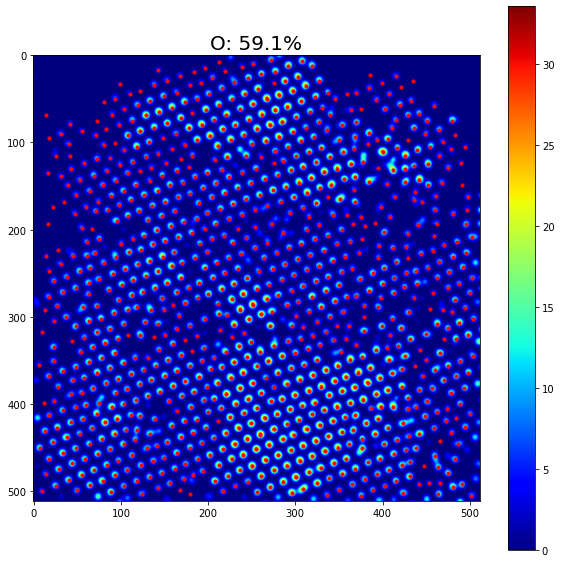

In [61]:
e = 'O'
idx = np.where(np.array(elements) == e)[0][0]

fig = plt.figure(figsize=(10,10))

plt.title(elements[idx] + ': {:.1f}%'.format(sum(CHs[idx])/CH_tot * 100)
          ,size = 20)
plt.imshow(pred_exp_img.numpy()[0,:,:,idx],cmap = 'jet')
plt.colorbar()
plt.scatter(peaks[idx][:,1],
           peaks[idx][:,0], c = 'r',s = 10)

**Composition from experiments**

- Cu: 12.33%
- Fe: 6.96%
- Mn: 7.61%
- Ni: 7.77%
- O: 57%
- Zn: 8.17%